In [ ]:
# ! pip install git+https://github.com/catalyst-team/catalyst@dev --upgrade

In [ ]:
# ! pip install scikit-learn>=0.20 optuna

###  Kittylyst demo

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_blobs
%matplotlib inline

In [2]:
from typing import *

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset

from catalyst import dl, metrics

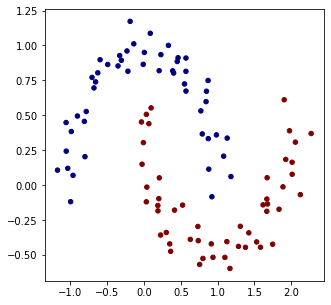

In [3]:
# make up a dataset
def make_dataset(seed=42, n_samples=100):
    np.random.seed(seed)
    random.seed(seed)
    X, y = make_moons(n_samples=100, noise=0.1)

    y = y*2 - 1 # make y be -1 or 1
    return X, y

def visualize_dataset(X, y):
    plt.figure(figsize=(5,5))
    plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

# let's create train data
X_train, y_train = make_dataset()
visualize_dataset(X_train, y_train)

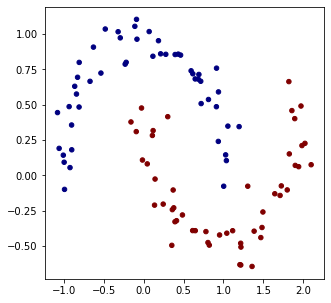

In [4]:
# valid data
X_valid, y_valid = make_dataset(seed=137)
visualize_dataset(X_valid, y_valid)

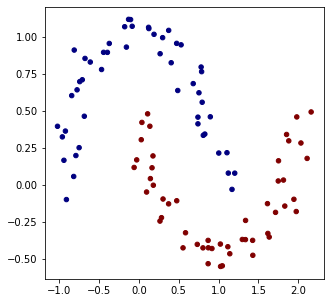

In [5]:
# and another train one (why not?)
X_train2, y_train2 = make_dataset(seed=1337)
visualize_dataset(X_train2, y_train2)

In [6]:
# initialize a model 
# 2-layer neural network
model = nn.Sequential(
    nn.Linear(2, 16), nn.ReLU(), 
    nn.Linear(16, 16), nn.ReLU(), 
    nn.Linear(16, 1)
)
print(model)
# print("number of parameters", len(model.parameters()))

Sequential(
  (0): Linear(in_features=2, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=1, bias=True)
)


In [7]:
def visualize_decision_boundary(X, y, model):
    h = 0.25
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Xmesh = np.c_[xx.ravel(), yy.ravel()]
    
    inputs = torch.tensor([list(xrow) for xrow in Xmesh]).float()
    scores = model(inputs)
    
    Z = np.array([s.data > 0 for s in scores])
    Z = Z.reshape(xx.shape)

    fig = plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()
    return fig

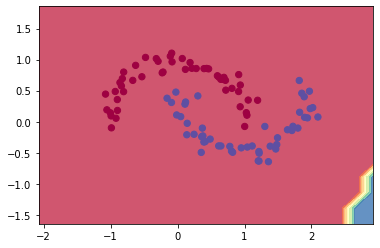

In [8]:
_ = visualize_decision_boundary(X_valid, y_valid, model)

In [9]:
t1 = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train > 0).float())
t2 = TensorDataset(torch.tensor(X_train2).float(), torch.tensor(y_train2 > 0).float())
v1 = TensorDataset(torch.tensor(X_valid).float(), torch.tensor(y_valid > 0).float())

loaders = {
    "train_1": DataLoader(t1, batch_size=32, num_workers=1), 
    "train_2": DataLoader(t2, batch_size=32, num_workers=1), 
    "valid": DataLoader(v1, batch_size=32, num_workers=1), 
}

---

### Act 1 - ``CustomRunner`` solution

Suppose you have your favorite `for-loop` pipeline and want to get rid of `for-for-for` stuff to make code more clean. In this case you can define your own ``CustomRunner`` with ``_handle_batch`` method and just run it.

Whole ``Runner`` source code is located [here](github.com/Scitator/kittylyst/blob/master/kittylyst/runner.py) (~100 lines of code).

In [10]:
# 2-layer neural network
model = nn.Sequential(
    nn.Linear(2, 16), nn.ReLU(), 
    nn.Linear(16, 16), nn.ReLU(), 
    nn.Linear(16, 1)
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
experiment = dl.SingleStageExperiment(
    model=model, 
    optimizer=optimizer, 
    loaders=loaders, 
    num_epochs=10
)

class CustomRunner(dl.IStageBasedRunner):
    def handle_batch(self, batch):
        x, y = batch
        y_hat = self.model(x)

        loss = F.binary_cross_entropy_with_logits(y_hat.view(-1), y)
        self.batch_metrics = {"loss": loss}
        print(
            f"{self.loader_key} ({self.loader_batch_step}/{self.loader_batch_len}:" 
            f"loss {loss.item()}"
        )

        if self.is_train_loader:
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

CustomRunner().run(experiment)

train_1 (1/4:loss 0.6469919681549072
train_1 (2/4:loss 0.6178137063980103
train_1 (3/4:loss 0.6484894752502441
train_1 (4/4:loss 0.610875129699707
train_2 (1/4:loss 0.5533329248428345
train_2 (2/4:loss 0.5496140718460083
train_2 (3/4:loss 0.45789992809295654
train_2 (4/4:loss 0.4393586814403534
valid (1/4:loss 0.4490053653717041
valid (2/4:loss 0.46768027544021606
valid (3/4:loss 0.42615780234336853
valid (4/4:loss 0.2692885100841522
train_1 (1/4:loss 0.44229644536972046
train_1 (2/4:loss 0.43654516339302063
train_1 (3/4:loss 0.3828589916229248
train_1 (4/4:loss 0.3995630145072937
train_2 (1/4:loss 0.3792839050292969
train_2 (2/4:loss 0.4501698911190033
train_2 (3/4:loss 0.32567906379699707
train_2 (4/4:loss 0.21003586053848267
valid (1/4:loss 0.3047797381877899
valid (2/4:loss 0.3261270821094513
valid (3/4:loss 0.3462640941143036
valid (4/4:loss 0.08599817752838135
train_1 (1/4:loss 0.30931150913238525
train_1 (2/4:loss 0.2722146213054657
train_1 (3/4:loss 0.3281630277633667
train_1 (

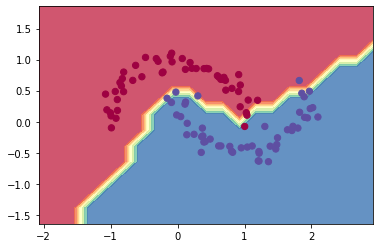

In [11]:
_ = visualize_decision_boundary(X_valid, y_valid, model)

---

### Act 2 - ``SupervisedRunner`` solution

Let's make a bit more abstract. Let's introduce ``SupervisedRunner``, that knows how to execute Supervised models and ``CriterionCallback/OptimizerCallback/SchedulerCallback`` for typical criterions/optimizers/schedulers steps. 

Additionaly let's wrap accuracy with ``AccuracyCallback``, as far as metrics are general too. 

Finally, let's make our logs looks consistent with ``LoggerCallback``.

Whole ``Callback`` source code is located [here](github.com/Scitator/kittylyst/blob/master/kittylyst/callback.py) (~100 lines of code).

In [12]:
num_epochs=6
model = nn.Sequential(
    nn.Linear(2, 16), nn.ReLU(), 
    nn.Linear(16, 16), nn.ReLU(), 
    nn.Linear(16, 1)
)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [3, 6])

experiment = dl.SingleStageExperiment(
    model=model, 
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    loaders=loaders, 
    num_epochs=num_epochs,
    callbacks={
        "criterion": dl.CriterionCallback(
            metric_key="loss", 
            input_key="logits", 
            target_key="targets"
        ), 
#         "accuracy": dl.MetricCallback(
#             metric=metrics.AccuracyMetric(), compute_on_batch=True,
#             output_key="logits", target_key="targets", 
#         ),
        "auc": dl.MetricCallback(
            metric=metrics.AUCMetric(), compute_on_batch=False,
            input_key="scores", target_key="targets", 
        ), 
        "optimizer": dl.OptimizerCallback(metric_key="loss"), 
        "scheduler": dl.SchedulerCallback(
            loader_key="valid", metric_key="loss"
        ),
        "checkpoint1": dl.CheckpointCallback(
            loader_key="valid", metric_key="auc", 
            minimize=False, save_n_best=3
        ),
        "checkpoint2": dl.CheckpointCallback(
            loader_key="valid", metric_key="loss", 
            minimize=True, save_n_best=1
        ),
        "verbose": dl.VerboseCallback(),
    },
    loggers={
        "console": dl.ConsoleLogger(),
        "csv": dl.LogdirLogger(logdir="./logdir"),
        "tensorboard": dl.TensorboardLogger(logdir="./logdir"),
    }
)

class CustomRunner(dl.IStageBasedRunner):
    def handle_batch(self, batch):
        x, y = batch
        y_hat = self.model(x)
        
        self.batch = {
            "features": x,
            "targets": y,
            "logits": y_hat.view(-1),
            "scores": torch.sigmoid(y_hat.view(-1)),
        }

CustomRunner().run(experiment)

Hparams (experiment): {}



train_1 (1/6) auc: 0.8515999913215637 | auc/class_01: 0.8515999913215637 | loss: 0.6774069690704345 | loss/std: 0.015066117249995174



train_2 (1/6) auc: 0.9340000152587891 | auc/class_01: 0.9340000152587891 | loss: 0.5996801209449768 | loss/std: 0.02110312839622848



valid (1/6) auc: 0.9376000165939331 | auc/class_01: 0.9376000165939331 | loss: 0.5371240508556365 | loss/std: 0.02091185827401528
checkpoint saved at  ./logpath.pth
checkpoint saved at  ./logpath.pth



train_1 (2/6) auc: 0.9340000152587891 | auc/class_01: 0.9340000152587891 | loss: 0.507241485118866 | loss/std: 0.02993508835862766



train_2 (2/6) auc: 0.9300000071525574 | auc/class_01: 0.9300000071525574 | loss: 0.434192498922348 | loss/std: 0.05112486468824183



valid (2/6) auc: 0.9408000111579895 | auc/class_01: 0.9408000111579895 | loss: 0.37482650578022003 | loss/std: 0.04658968369059159
checkpoint saved at  ./logpath.pth
checkpoint saved at  ./logpath.pth



train_1 (3/6) auc: 0.9383999705314636 | auc/class_01: 0.9383999705314636 | loss: 0.36489189863204957 | loss/std: 0.021639398504284493



train_2 (3/6) auc: 0.9467999935150146 | auc/class_01: 0.9467999935150146 | loss: 0.3225413328409195 | loss/std: 0.029789896667858907



valid (3/6) auc: 0.9584000110626221 | auc/class_01: 0.9584000110626221 | loss: 0.278597872108221 | loss/std: 0.05048417260202923
checkpoint saved at  ./logpath.pth
checkpoint saved at  ./logpath.pth



train_1 (4/6) auc: 0.9580000042915344 | auc/class_01: 0.9580000042915344 | loss: 0.2806558620929718 | loss/std: 0.039492878708056324



train_2 (4/6) auc: 0.9552000164985657 | auc/class_01: 0.9552000164985657 | loss: 0.28739032268524173 | loss/std: 0.02197123820994376



valid (4/6) auc: 0.9599999785423279 | auc/class_01: 0.9599999785423279 | loss: 0.2722929693758488 | loss/std: 0.04989590070791587
checkpoint saved at  ./logpath.pth
checkpoint saved at  ./logpath.pth



train_1 (5/6) auc: 0.9611999988555908 | auc/class_01: 0.9611999988555908 | loss: 0.2741867971420288 | loss/std: 0.03812901279789116



train_2 (5/6) auc: 0.9563999772071838 | auc/class_01: 0.9563999772071838 | loss: 0.28132986307144164 | loss/std: 0.02255802845089023



valid (5/6) auc: 0.9624000191688538 | auc/class_01: 0.9624000191688538 | loss: 0.2665697357058525 | loss/std: 0.04826460572939384
checkpoint saved at  ./logpath.pth
checkpoint saved at  ./logpath.pth



train_1 (6/6) auc: 0.9628000259399414 | auc/class_01: 0.9628000259399414 | loss: 0.2685170793533325 | loss/std: 0.03525054773807415



train_2 (6/6) auc: 0.9584000110626221 | auc/class_01: 0.9584000110626221 | loss: 0.27606665432453154 | loss/std: 0.02339177378207804



valid (6/6) auc: 0.9656000137329102 | auc/class_01: 0.9656000137329102 | loss: 0.26132327303290365 | loss/std: 0.04653452148474865
checkpoint saved at  ./logpath.pth
checkpoint saved at  ./logpath.pth
Top-N best epochs:
6	0.9656
5	0.9624
4	0.9600
checkpoint loaded from  ./logpath.pth
Top-N best epochs:
6	0.2613
checkpoint loaded from  ./logpath.pth


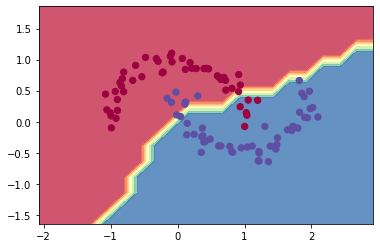

In [13]:
_ = visualize_decision_boundary(X_valid, y_valid, model)

---

### Act 3 - ``CustomExperiment`` solution - multi-stage experiment with ``VisualizationCallback``

Let's go even harder. Suppose we want to firstly train our model on `train_1` data, and only after that - on `train_2`. This case could be easily handled with ``CustomExperiment``, where you could redefine your experiment components for each stage of your experiment.

Whole ``Experiemnt`` source code is located [here](github.com/Scitator/kittylyst/blob/master/kittylyst/experiment.py) (~100 lines of code).

In [14]:
import io
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_img_from_fig(fig, dpi=180):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=dpi)
    buf.seek(0)
    
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [15]:
class CustomExperiment(dl.SingleStageExperiment):
    @property
    def stages(self):
        return self._stage

    def get_loaders(self, stage: str):
        return self._loaders[stage]

    
# class VisualizationCallback(ICallback):
#     def on_epoch_end(self, runner):
#         img = visualize_decision_boundary(X_valid, y_valid, runner.model)
#         img = get_img_from_fig(img)
#         runner.log_image(img, scope="epoch")

        
loaders = {
    "stage_1": {
        "train_1": DataLoader(t1, batch_size=32, num_workers=1), 
        "valid": DataLoader(v1, batch_size=32, num_workers=1), 
    },
    "stage_2": {
        "train_2": DataLoader(t2, batch_size=32, num_workers=1), 
        "valid": DataLoader(v1, batch_size=32, num_workers=1), 
    },
}
stages = loaders.keys()
num_epochs=10

model = nn.Sequential(
    nn.Linear(2, 16), nn.ReLU(), 
    nn.Linear(16, 16), nn.ReLU(), 
    nn.Linear(16, 1)
)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [3, 6])

experiment = CustomExperiment(
    model=model, 
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    loaders=loaders, 
    num_epochs=num_epochs,
    callbacks={
        "criterion": dl.CriterionCallback(
            metric_key="loss", 
            input_key="logits", 
            target_key="targets"
        ), 
#         "accuracy": dl.MetricCallback(
#             metric=metrics.AccuracyMetric(), compute_on_batch=True,
#             output_key="logits", target_key="targets", 
#         ),
        "auc": dl.MetricCallback(
            metric=metrics.AUCMetric(), compute_on_batch=False,
            input_key="scores", target_key="targets", 
        ), 
        "optimizer": dl.OptimizerCallback(metric_key="loss"), 
        "scheduler": dl.SchedulerCallback(
            loader_key="valid", metric_key="loss"
        ),
        "checkpoint1": dl.CheckpointCallback(
            loader_key="valid", metric_key="auc", 
            minimize=False, save_n_best=3
        ),
        "checkpoint2": dl.CheckpointCallback(
            loader_key="valid", metric_key="loss", 
            minimize=True, save_n_best=1
        ),
#         "visualization": VisualizationCallback(),
#         "verbose": VerboseCallback(),
        
    },
    loggers={
#         "console": ConsoleLogger(exclude=["batch", "global_batch", "loader", "global_epoch"]),
        "console": dl.ConsoleLogger(),
        "csv": dl.LogdirLogger(logdir="./logdir2"),
    },
    stage=stages  # <-- here is the trick for multi-stage support
)

class CustomRunner(dl.IStageBasedRunner):
    def handle_batch(self, batch):
        x, y = batch
        y_hat = self.model(x)
        
        self.batch = {
            "features": x,
            "targets": y,
            "logits": y_hat.view(-1),
            "scores": torch.sigmoid(y_hat.view(-1)),
        }

CustomRunner().run(experiment)

Hparams (experiment): {}
train_1 (1/10) auc: 0.628000020980835 | auc/class_01: 0.628000020980835 | loss: 0.6842921042442323 | loss/std: 0.016516368242907815
valid (1/10) auc: 0.9100000262260437 | auc/class_01: 0.9100000262260437 | loss: 0.6321618318557739 | loss/std: 0.012280290277671588
checkpoint saved at  ./logpath.pth
checkpoint saved at  ./logpath.pth
train_1 (2/10) auc: 0.91839998960495 | auc/class_01: 0.91839998960495 | loss: 0.6048205184936524 | loss/std: 0.009740330591301373
valid (2/10) auc: 0.9276000261306763 | auc/class_01: 0.9276000261306763 | loss: 0.5470819795131683 | loss/std: 0.02274503484738651
checkpoint saved at  ./logpath.pth
checkpoint saved at  ./logpath.pth
train_1 (3/10) auc: 0.9300000071525574 | auc/class_01: 0.9300000071525574 | loss: 0.5178400063514709 | loss/std: 0.0312879205471755
valid (3/10) auc: 0.9387999773025513 | auc/class_01: 0.9387999773025513 | loss: 0.46028956055641174 | loss/std: 0.03841862532952897
checkpoint saved at  ./logpath.pth
checkpoint 

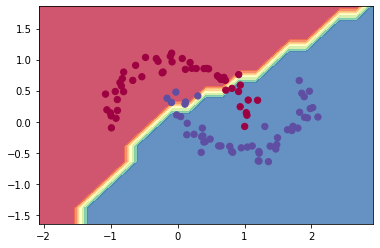

In [16]:
_ = visualize_decision_boundary(X_valid, y_valid, model)

### Act 4 - integration with hyperparameter search

In [17]:
from datetime import datetime
import optuna    

class CustomRunner(dl.IStageBasedRunner):
    def handle_batch(self, batch):
        x, y = batch
        y_hat = self.model(x)
        
        self.batch = {
            "features": x,
            "targets": y,
            "logits": y_hat.view(-1),
            "scores": torch.sigmoid(y_hat.view(-1)),
        }

def objective(trial):
    num_epochs = 6
    num_hidden1 = int(trial.suggest_loguniform("num_hidden1", 2, 16))
    num_hidden2 = int(trial.suggest_loguniform("num_hidden2", 2, 16))
    
    loaders = {
        "train_1": DataLoader(t1, batch_size=32, num_workers=1), 
        "train_2": DataLoader(t2, batch_size=32, num_workers=1), 
        "valid": DataLoader(v1, batch_size=32, num_workers=1), 
    }

    model = nn.Sequential(
        nn.Linear(2, num_hidden1), nn.ReLU(), 
        nn.Linear(num_hidden1, num_hidden2), nn.ReLU(), 
        nn.Linear(num_hidden2, 1)
    )
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [3, 6])

    experiment = dl.SingleStageExperiment(
        model=model, 
        criterion=criterion, 
        optimizer=optimizer, 
        scheduler=scheduler,
        loaders=loaders, 
        num_epochs=num_epochs,
        callbacks={
            "criterion": dl.CriterionCallback(
                metric_key="loss", 
                input_key="logits", 
                target_key="targets"
            ), 
    #         "accuracy": dl.MetricCallback(
    #             metric=metrics.AccuracyMetric(), compute_on_batch=True,
    #             output_key="logits", target_key="targets", 
    #         ),
            "auc": dl.MetricCallback(
                metric=metrics.AUCMetric(), compute_on_batch=False,
                input_key="scores", target_key="targets", 
            ), 
            "optimizer": dl.OptimizerCallback(metric_key="loss"), 
            "scheduler": dl.SchedulerCallback(
                loader_key="valid", metric_key="loss"
            ),
            "checkpoint": dl.CheckpointCallback(
                loader_key="valid", metric_key="auc", 
                minimize=False, save_n_best=3
            ),
            "optuna": dl.OptunaPruningCallback(loader_key="valid", metric_key="auc")
        },
        loggers={
            "console": dl.ConsoleLogger(),
            "csv": dl.LogdirLogger(logdir=f"./logdir/{datetime.now().strftime('%Y%m%d-%H%M%S')}"),
        },
        trial=trial,
#         hparams={"l2_alpha": l2_alpha, "num_hidden1": num_hidden1, "num_hidden2": num_hidden2},
    )

    runner = CustomRunner()
    runner.run(experiment)
    score = runner.callbacks["checkpoint"].top_best_metrics[0][0]
    
    return score

study = optuna.create_study(
    direction="maximize",
#     direction="minimize",
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=0, n_warmup_steps=0, interval_steps=1
    ),
)
study.optimize(objective, n_trials=5, timeout=300)
print(study.best_value, study.best_params)

[I 2021-01-20 09:44:01,392] A new study created in memory with name: no-name-880fac78-f078-49c7-932a-9b9ed9dd1c5a


Hparams (experiment_0): {'num_hidden1': 8.263294265945335, 'num_hidden2': 4.438153336016769}
train_1 (1/6) auc: 0.6783999800682068 | auc/class_01: 0.6783999800682068 | loss: 0.6910026359558106 | loss/std: 0.021651712132023906
train_2 (1/6) auc: 0.9151999950408936 | auc/class_01: 0.9151999950408936 | loss: 0.662529706954956 | loss/std: 0.015474331685687107
valid (1/6) auc: 0.9264000058174133 | auc/class_01: 0.9264000058174133 | loss: 0.6481062459945679 | loss/std: 0.007564122604709736
checkpoint saved at  ./logpath.pth
train_1 (2/6) auc: 0.9179999828338623 | auc/class_01: 0.9179999828338623 | loss: 0.6429541659355164 | loss/std: 0.01518989417535695
train_2 (2/6) auc: 0.9151999950408936 | auc/class_01: 0.9151999950408936 | loss: 0.6179243803024292 | loss/std: 0.020056221889770087
valid (2/6) auc: 0.9327999949455261 | auc/class_01: 0.9327999949455261 | loss: 0.5928013038635255 | loss/std: 0.014132131420503253
checkpoint saved at  ./logpath.pth
train_1 (3/6) auc: 0.9287999868392944 | auc/c

[I 2021-01-20 09:44:02,229] Trial 0 finished with value: 0.9535999894142151 and parameters: {'num_hidden1': 8.263294265945335, 'num_hidden2': 4.438153336016769}. Best is trial 0 with value: 0.9535999894142151.


valid (6/6) auc: 0.9435999989509583 | auc/class_01: 0.9435999989509583 | loss: 0.4965479958057404 | loss/std: 0.03771006812223542
Top-N best epochs:
4	0.9536
3	0.9532
2	0.9328
checkpoint loaded from  ./logpath.pth
Hparams (experiment_1): {'num_hidden1': 2.0604543887458577, 'num_hidden2': 2.4508933145575167}
train_1 (1/6) auc: 0.8151999711990356 | auc/class_01: 0.8151999711990356 | loss: 0.7219933748245239 | loss/std: 0.06399150319487835
train_2 (1/6) auc: 0.91839998960495 | auc/class_01: 0.91839998960495 | loss: 0.6850658798217774 | loss/std: 0.04516671399308017
valid (1/6) auc: 0.951200008392334 | auc/class_01: 0.951200008392334 | loss: 0.664085214138031 | loss/std: 0.018880011726704414
checkpoint saved at  ./logpath.pth
train_1 (2/6) auc: 0.9467999935150146 | auc/class_01: 0.9467999935150146 | loss: 0.6507284522056579 | loss/std: 0.02873818372780482
train_2 (2/6) auc: 0.9348000288009644 | auc/class_01: 0.9348000288009644 | loss: 0.6124857878684997 | loss/std: 0.01312045335901199
vali

[I 2021-01-20 09:44:02,684] Trial 1 pruned. Trial was pruned at epoch 3.


valid (3/6) auc: 0.9448000192642212 | auc/class_01: 0.9448000192642212 | loss: 0.4678910088539123 | loss/std: 0.028254662881814517
Hparams (experiment_2): {'num_hidden1': 14.134270344891974, 'num_hidden2': 4.796845703050038}
train_1 (1/6) auc: 0.5335999727249146 | auc/class_01: 0.5335999727249146 | loss: 0.7092610597610474 | loss/std: 0.04600730375405102
train_2 (1/6) auc: 0.8284000158309937 | auc/class_01: 0.8284000158309937 | loss: 0.6921103620529174 | loss/std: 0.03301978115978808


[I 2021-01-20 09:44:02,825] Trial 2 pruned. Trial was pruned at epoch 1.


valid (1/6) auc: 0.909600019454956 | auc/class_01: 0.909600019454956 | loss: 0.6734217405319214 | loss/std: 0.012477120957435842
checkpoint saved at  ./logpath.pth
Hparams (experiment_3): {'num_hidden1': 3.6507107563587278, 'num_hidden2': 2.1459785876328556}
train_1 (1/6) auc: 0.8600000143051147 | auc/class_01: 0.8600000143051147 | loss: 0.654337899684906 | loss/std: 0.024423631565093154
train_2 (1/6) auc: 0.8812000155448914 | auc/class_01: 0.8812000155448914 | loss: 0.6145412611961365 | loss/std: 0.0138885957104187


[I 2021-01-20 09:44:02,984] Trial 3 pruned. Trial was pruned at epoch 1.


valid (1/6) auc: 0.9016000032424927 | auc/class_01: 0.9016000032424927 | loss: 0.5876585936546326 | loss/std: 0.019021726258296155
checkpoint saved at  ./logpath.pth
Hparams (experiment_4): {'num_hidden1': 8.058395014907276, 'num_hidden2': 11.124573975781543}
train_1 (1/6) auc: 0.46160000562667847 | auc/class_01: 0.46160000562667847 | loss: 0.6940280532836914 | loss/std: 0.011669313931890983
train_2 (1/6) auc: 0.8871999979019165 | auc/class_01: 0.8871999979019165 | loss: 0.6809967947006226 | loss/std: 0.006588423085691335
valid (1/6) auc: 0.8695999979972839 | auc/class_01: 0.8695999979972839 | loss: 0.6656296443939209 | loss/std: 0.005347236832195606
checkpoint saved at  ./logpath.pth


[I 2021-01-20 09:44:03,192] Trial 4 pruned. Trial was pruned at epoch 1.


0.9535999894142151 {'num_hidden1': 8.263294265945335, 'num_hidden2': 4.438153336016769}


### Act 5 - fully custom experiment

In [18]:
class CustomExperiment(dl.IExperiment):
    @property
    def seed(self) -> int:
        return 73

    @property
    def name(self) -> str:
        # @TODO: auto-generate name?
        return "experiment73"

    @property
    def hparams(self) -> Dict:
        return {}

    @property
    def stages(self) -> List[str]:
        return ["stage_1", "stage_2"]

    def get_stage_params(self, stage: str) -> Dict[str, Any]:
        if stage == "stage_1":
            return {
                "num_epochs": 10,
                "migrate_model_from_previous_stage": False,
                "migrate_callbacks_from_previous_stage": False,
            }
        elif stage == "stage_2":
            return {
                "num_epochs": 6,
                "migrate_model_from_previous_stage": True,
                "migrate_callbacks_from_previous_stage": False,
            }
        else:
            raise NotImplemented()

    def get_loaders(self, stage: str) -> Dict[str, Any]:
        if stage == "stage_1":
            return {
                "train_1": DataLoader(t1, batch_size=32, num_workers=1), 
                "valid": DataLoader(v1, batch_size=32, num_workers=1), 
            }
        elif stage == "stage_2":
            return {
                "train_2": DataLoader(t2, batch_size=32, num_workers=1), 
                "valid": DataLoader(v1, batch_size=32, num_workers=1), 
            }
        else:
            raise NotImplemented()

    def get_model(self, stage: str):
        return nn.Sequential(
            nn.Linear(2, 16), nn.ReLU(), 
            nn.Linear(16, 16), nn.ReLU(), 
            nn.Linear(16, 1)
        )

    def get_criterion(self, stage: str):
        return nn.BCEWithLogitsLoss()

    def get_optimizer(self, stage: str, model):
        if stage == "stage_1":
            return torch.optim.Adam(model.parameters(), lr=0.02)
        elif stage == "stage_2":
            return torch.optim.SGD(model.parameters(), lr=0.01)
        else:
            raise NotImplemented()

    def get_scheduler(self, stage: str, optimizer):
        if stage == "stage_1":
            return torch.optim.lr_scheduler.MultiStepLR(optimizer, [3, 8])
        elif stage == "stage_2":
            return torch.optim.lr_scheduler.MultiStepLR(optimizer, [3, 6])
        else:
            raise NotImplemented()
        

    def get_callbacks(self, stage: str) -> Dict[str, dl.Callback]:
        if stage == "stage_1":
            
            return {
                "criterion": dl.CriterionCallback(
                    metric_key="loss", 
                    input_key="logits", 
                    target_key="targets"
                ), 
#                 "accuracy": dl.MetricCallback(
#                     metric=metrics.AccuracyMetric(), compute_on_batch=True,
#                     output_key="logits", target_key="targets", 
#                 ),
#                 "auc": dl.MetricCallback(
#                     metric=metrics.AUCMetric(), compute_on_batch=False,
#                     output_key="scores", target_key="targets", 
#                 ), 
                "optimizer": dl.OptimizerCallback(metric_key="loss"), 
                "scheduler": dl.SchedulerCallback(
                    loader_key="valid", metric_key="loss"
                ),
                "checkpoint": dl.CheckpointCallback(
                    loader_key="valid", metric_key="loss", 
                    minimize=True, save_n_best=3
                ),
            }
        elif stage == "stage_2":
            return {
                "criterion": dl.CriterionCallback(
                    metric_key="loss", 
                    input_key="logits", 
                    target_key="targets"
                ), 
                "auc": dl.MetricCallback(
                    metric=metrics.AUCMetric(), compute_on_batch=False,
                    input_key="scores", target_key="targets", 
                ), 
                "optimizer": dl.OptimizerCallback(metric_key="loss"), 
                "scheduler": dl.SchedulerCallback(
                    loader_key="valid", metric_key="loss"
                ),
                "checkpoint_auc": dl.CheckpointCallback(
                    loader_key="valid", metric_key="auc", 
                    minimize=False, save_n_best=3
                ),
            }
        else:
            raise NotImplemented()
        

    def get_engine(self):
        return dl.Engine()

    def get_trial(self):
        return None

    def get_loggers(self):
        return {
            "console": dl.ConsoleLogger(),
            "csv": dl.LogdirLogger(logdir="./logdir5"),
        }

    
class CustomRunner(dl.IStageBasedRunner):
    def handle_batch(self, batch):
        x, y = batch
        y_hat = self.model(x)
        
        self.batch = {
            "features": x,
            "targets": y,
            "logits": y_hat.view(-1),
            "scores": torch.sigmoid(y_hat.view(-1)),
        }
    
experiment = CustomExperiment()
CustomRunner().run(experiment)

Hparams (experiment73): {}
train_1 (1/10) loss: 0.6554987812042237 | loss/std: 0.010964926683879592
valid (1/10) loss: 0.592820405960083 | loss/std: 0.013404487100205743
checkpoint saved at  ./logpath.pth
train_1 (2/10) loss: 0.5644180583953857 | loss/std: 0.019220165048759556
valid (2/10) loss: 0.49304522514343263 | loss/std: 0.02807273757878892
checkpoint saved at  ./logpath.pth
train_1 (3/10) loss: 0.4591502058506012 | loss/std: 0.029442021060177036
valid (3/10) loss: 0.3757249855995178 | loss/std: 0.03750348035124905
checkpoint saved at  ./logpath.pth
train_1 (4/10) loss: 0.3698853898048401 | loss/std: 0.012937625416118191
valid (4/10) loss: 0.36558716416358944 | loss/std: 0.0377596294729329
checkpoint saved at  ./logpath.pth
train_1 (5/10) loss: 0.3602266240119934 | loss/std: 0.01471463446294061
valid (5/10) loss: 0.3560610342025757 | loss/std: 0.03785174363952334
checkpoint saved at  ./logpath.pth
train_1 (6/10) loss: 0.351167676448822 | loss/std: 0.016884154862839472
valid (6/10

---

🎉 You have passed ``Kittylyst`` tutorial! This is just a minimal educational demo, but I hope you found it interesting for your deep learning research code organisation.

For more advanced and production-ready solution please follow our [Catalyst](https://github.com/catalyst-team/catalyst) repository.

PS. If you are interested in deep learning you could also try out our [dl-course](https://github.com/catalyst-team/dl-course).